# Simulation Sample Preparation

In this notebook I setup the different samples I'm going to use for each experiment to test the spaceNNtime neural net.

<a name="Home3"></a>

## Contents

0. [ Library and packages ](#Lib)
1. [ Metadata Preparation ](#Met)
    + 1. [ Downsampling and Gold ](#Dow)
    + 2. [ Real ](#Rea)

<a name="Lib"></a>
## 0. Library and packages

In [1]:
import pandas as pd

%load_ext rpy2.ipython

In [2]:
%%R

library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;


<a name="Met"></a>
## 1. Metadata Preparation


<a name="Dow"></a>
### A. Downsampling and Gold




In [3]:
%%bash

mkdir -p /home/moicoll/spaceNNtime/data/europe/metadata

In [4]:
metadata = pd.read_csv("/home/moicoll/spaceNNtime/data/europe/metadata.txt", sep = "\t")

prev_metadata = metadata
for name, n in zip([12, 13, 14, 5, 15, 16, 17], [15_000, 10_000, 5_000, 1_500, 1_000, 500, 250]):
    prev_metadata = prev_metadata.sample(n=n, replace=False, random_state=1234, axis=None, ignore_index=False)
    prev_metadata.to_csv("/home/moicoll/spaceNNtime/data/europe/metadata/{}.txt".format(name), sep='\t', index=False, doublequote=False)

In [5]:
%%bash

head /home/moicoll/spaceNNtime/data/europe/metadata/5.txt

ind_id	pop	time	sampled	lat	lon	node1	node2
42784	EUR	3867	True	53.605454360429	30.5757413717946	28034	28035
8161	OOA	40760	True	37.3355221812401	58.2851504133887	6078	6079
12398	OOA	35375	True	37.8928083391232	62.8855568099032	9226	9227
42047	ANA	4799	True	56.2063242700915	35.6497041110234	27532	27533
43565	EUR	3097	True	52.4295033738886	19.1184746436291	28524	28525
32738	EUR	14297	True	56.0974448892277	29.6509632238033	21904	21905
43503	YAM	3148	True	54.8271849112524	20.8741353181669	28492	28493
17147	OOA	29641	True	37.6727340995128	63.5282266466246	12768	12769
11950	OOA	35937	True	38.7230626139012	59.6498465939826	8892	8893


In [8]:
%%bash

for name in 12 13 14 5 16 17;
    do
    wc -l /home/moicoll/spaceNNtime/data/europe/metadata/${name}.txt
done

15001 /home/moicoll/spaceNNtime/data/europe/metadata/12.txt
10001 /home/moicoll/spaceNNtime/data/europe/metadata/13.txt
5001 /home/moicoll/spaceNNtime/data/europe/metadata/14.txt
1501 /home/moicoll/spaceNNtime/data/europe/metadata/5.txt
501 /home/moicoll/spaceNNtime/data/europe/metadata/16.txt
251 /home/moicoll/spaceNNtime/data/europe/metadata/17.txt


[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;

<a name="Rea"></a>
### B. Real

In this experiment, I'll try to match the sampling distribution in the temporal dimention of the MesoNeo data. For that, I have explored the distribution in that axis in the real data and grouped samples in windows of 1,000 years and counted how many samples do I get for each temporal bin. I obtained the data below.

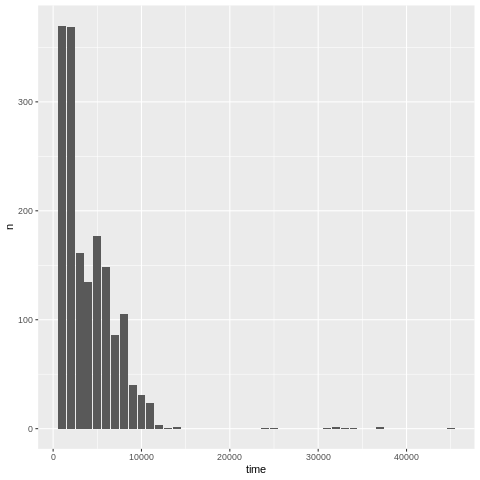

In [9]:
%%R

mesoneo_temp_bins_n = data.frame(time = c(1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000,  9000, 10000, 11000, 12000, 13000, 14000, 24000, 25000, 31000, 32000, 33000, 34000, 37000, 45000),
                                 n     = c( 370,  369,  161,  135,  177,  148,   86,  105,    40,    31,    24,     3,     1,     2,     1,     1,     1,     2,     1,     1,     2,     1)) 
mesoneo_temp_bins_n %>%
    ggplot() +
    geom_bar(stat = "identity", aes(x = time, y = n))

In [10]:
%%R

mesoneo_temp_bins_n %>%
    summarize(n = sum(n))

     n
1 1662


In [11]:
%%R

metadata = read.table("/home/moicoll/spaceNNtime/data/europe/metadata/12.txt", header = T) 

metadata %>% head()

  ind_id pop  time sampled      lat      lon node1 node2
1  22333 EUR 24463    True 37.62332 35.12903 15824 15825
2  44487 EUR  2105    True 43.56728 20.30472 29118 29119
3  36478 ANA 10553    True 37.13947 32.00792 24092 24093
4  34047 ANA 12953    True 39.44802 36.29797 22700 22701
5  38827 EHG  8323    True 51.82672 12.54189 25466 25467
6   4667 OOA 45230    True 29.30174 47.36169  3418  3419


In [12]:
%%R 

mesoneo_downsampled = data.frame()

set.seed(1234)

for(t in mesoneo_temp_bins_n$time){
    n_rea = mesoneo_temp_bins_n %>% filter(time == t) %>% pull(n)
    n_sim = metadata %>% filter(t <= time, t+1000 > time) %>% nrow()
    if(n_sim < n_rea){
        mesoneo_downsampled = rbind(mesoneo_downsampled, metadata %>% filter(t <= time, t+1000 > time))
    }else{
        mesoneo_downsampled = rbind(mesoneo_downsampled, metadata %>% filter(t <= time, t+1000 > time) %>% sample_n(n_rea, replace = FALSE))
    }
                                     
}


In [13]:
%%R

mesoneo_downsampled %>%
    dim()

[1] 1499    8


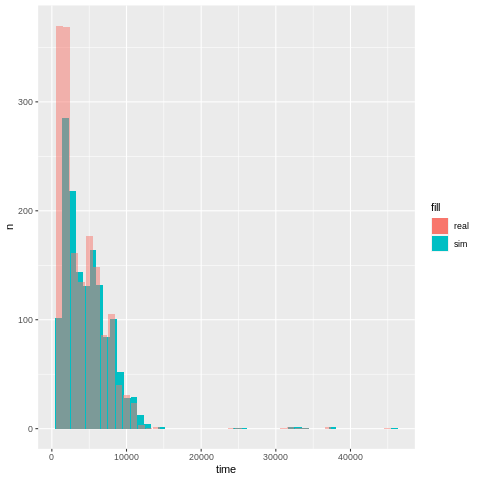

In [14]:
%%R

mesoneo_downsampled %>% 
    ggplot() +
    geom_histogram(aes(x = time, fill = "sim"), bins = 50) +
    geom_bar(data = mesoneo_temp_bins_n, stat = "identity", aes(x = time, y = n, fill = "real"), alpha = 0.5)

In [15]:
%%R

write.table(x = mesoneo_downsampled, file = "/home/moicoll/spaceNNtime/data/europe/metadata/18.txt", append = FALSE, sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [16]:
%%bash

head /home/moicoll/spaceNNtime/data/europe/metadata/18.txt
echo ""
head /home/moicoll/spaceNNtime/data/europe/metadata/12.txt

ind_id	pop	time	sampled	lat	lon	node1	node2
44726	EUR	1839	True	47.4840536299083	24.7323827775943	29286	29287
44743	EUR	1798	True	45.6570197191665	20.8907623356569	29304	29305
45268	EUR	1000	True	48.069668329689	2.40486894275938	29736	29737
44760	EUR	1789	True	47.800812693993	27.3801873885939	29314	29315
45189	EUR	1150	True	43.4340286541643	26.6507325099244	29646	29647
44816	EUR	1708	True	43.7140206117043	4.00431106401085	29376	29377
44795	EUR	1759	True	44.3649239898658	20.0578594259468	29346	29347
45085	EUR	1340	True	49.4515427603467	21.6612455141949	29558	29559
44693	EUR	1860	True	51.420381220628	9.41977112554445	29256	29257

ind_id	pop	time	sampled	lat	lon	node1	node2
22333	EUR	24463	True	37.6233169117395	35.1290327524117	15824	15825
44487	EUR	2105	True	43.5672844706891	20.3047164869021	29118	29119
36478	ANA	10553	True	37.1394680565021	32.0079192307929	24092	24093
34047	ANA	12953	True	39.4480158641814	36.2979709518097	22700	22701
38827	EHG	8323	True	51.8267153434264	12.5418869819229

In [17]:
%%bash

wc -l /home/moicoll/spaceNNtime/data/europe/metadata/18.txt

1500 /home/moicoll/spaceNNtime/data/europe/metadata/18.txt


[<img src="arrow.png" width="100" style="float: left;">](#Home3) &nbsp;

&nbsp;